# Dépendances

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import math as m
import random

def distance(a,b):
    (x1,y1),(x2,y2) = (a,b)
    return np.sqrt((x1-x2)**2+(y1-y2)**2) 

#### Dependencies to run pygame GUI

In [3]:
!pip install pygame

     |████████████████████████████████| 11.5MB 12.3MB/s 


In [4]:
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time 
import os, sys

In [5]:
# set SDL to use the dummy NULL video driver, 
#   so it doesn't need a windowing system.
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Déclaration et initialisation
Problème TSP

In [6]:
# Latitude longitude
_CITIES = (
    ("Bordeaux", (44.833333,-0.566667)), 
    ("Paris",(48.8566969,2.3514616)),
    ("Nice",(43.7009358,7.2683912)),
    ("Lyon",(45.7578137,4.8320114)),
    ("Nantes",(47.2186371,-1.5541362)),
    ("Brest",(48.4,-4.483333)),
    ("Lille",(50.633333,3.066667)),
    ("Clermont-Ferrand",(45.783333,3.083333)),
    ("Strasbourg",(48.583333,7.75)),
    ("Poitiers",(46.583333,0.333333)),
    ("Angers",(47.466667,-0.55)),
    ("Montpellier",(43.6,3.883333)),
    ("Caen",(49.183333,-0.35)),
    ("Rennes",(48.083333,-1.683333)),
    ("Pau",(43.3,-0.366667))
)

_NODES = len(_CITIES)
epsilon = 0.0001
gamma = 0.2

# Architecture

### Classe Map

In [7]:
class Map:
    def __init__(self):
        self.adj_mat = np.ones((_NODES,_NODES))/_NODES
        self.pheromones_to_add = np.zeros((_NODES,_NODES))
    
    def add_pheromones(self, quantity, path):
        # for each path arc
        for i in range(len(path)-1):
          node_ini, node_end = path[i], path[i+1]
          #extract index of node :
          index_ini, index_end = _CITIES.index(node_ini), _CITIES.index(node_end)
          #Add pheromones in the good arc
          self.pheromones_to_add[index_ini,index_end]+=quantity
          self.pheromones_to_map()
    
    def pheromones_to_map(self,ro=0.8):
        self.adj_mat= ro*self.adj_mat + self.pheromones_to_add
    
    def normalize_pheromones(self):
        self.adj_mat/=np.sum(self.adj_mat)
    
    def get_pheromones_intensity(self, node_ini, node_end):
        index_ini = _CITIES.index(node_ini)
        index_end = _CITIES.index(node_end)
        return self.adj_mat[index_ini,index_end]

    def path_from_adj_mat(self):
        adj_mat_copy = self.adj_mat.copy()
        tab=[0]
        for _ in range(_NODES):
          if (np.argmax(adj_mat_copy[tab[-1],:]) in tab):
            adj_mat_copy[tab[-1],np.argmax(adj_mat_copy[tab[-1],:])]=0
          tab.append(np.argmax(adj_mat_copy[tab[-1],:]))
        return [(i,_CITIES[i][0]) for i in tab]

    def path_length_from_adj_mat(self):
      path = self.path_from_adj_mat()
      coords_path = [_CITIES[x[0]][1] for x in path]
      path_distance_tab = [distance(coords_path[i], coords_path[i+1]) for i in range(len(coords_path)-1)]
      return np.sum(path_distance_tab)

    def print_results(self):
      #Print Adj mat
      data = self.adj_mat
      fig, ax = plt.subplots()
      im = ax.imshow(data, cmap=plt.get_cmap('hot'), interpolation='nearest',
                        vmin=np.min(data), vmax=np.max(data))
      fig.colorbar(im)
      plt.show()
      # Path & length
      print(self.path_from_adj_mat())
      print(self.path_length_from_adj_mat())
      return 0

    def __str__(self):
        print(f"Adj mat of pheromones :\n{self.adj_mat}")
        return ""

### Classe Fourmi

In [23]:
class Fourmi:
    __prenoms__=["Gabrielle", "Alphonse", "Kevin", "Loana", "Fleche","Mimi","Marguerite","Pomme","Hercule","Gigantor","Atlas","Tom","Rachelle","Violette","MiniPouce","Rinie","Pitchoune","Josie","Lucie","Garfield","Rose","Greg","Laurent","Florian","Solene","Cathy","Marie","Isabelle","Arnaud","Paul","Lea","Quentin","Marine","Brigitte","Judith","Sucrine","Mirabelle","Citrouille","Ange","Cléopatre","Cléo"]
    def __init__(self, position:tuple):
        '''
        Creates an ant with \n
        - an initial position \n
        - a list of string (a memory of visited cities)
        '''
        self.pos = position if position is not None else None
        self.cities = [position]
        self.quality = 5
        self.prenom = Fourmi.__prenoms__[random.randint(0,len(Fourmi.__prenoms__)-1)]
    
    def choose_movement(self, map:Map, a=0.8, b=0.6):
        '''
        Returns a tuple (initial_node, future_node) for the ant
        '''
        #Une fourmi ne peut visiter qu'une fois chaque ville
        possible_move=[]

        # Cas 1 : on n a pas encore visité toutes les villes
        if(len(self.cities) < len(_CITIES)):
          
          for city in _CITIES:
              if(city not in self.cities):
                  possible_move.append(city)
          if(len(possible_move)>0):
              #Les villes proches ont plus de chance d'être choisies => softmax
              distances = []
              for city in possible_move:
                  distances.append(distance(self.pos[1],city[1])) # distance ini-arrivée
              
              visibility = [1/(x+epsilon) for x in distances]
              powered_visibility = np.array(visibility)**b

              pheromones_intensity = [map.get_pheromones_intensity(self.pos,city) for city in possible_move]
              powered_pheromones_intensity = np.array(pheromones_intensity)**a
              
              chances =  (gamma + powered_visibility * powered_pheromones_intensity) / np.sum((gamma + powered_visibility * powered_pheromones_intensity)) #softmax(visibility)

              #for i in range(len(possible_move)):
                  #print(f"Score de {self.pos[0]} à {possible_move[i][0]} : visibility {np.round(visibility[i],1)}, pheromones {np.round(pheromones_intensity[i],1)},chance {np.round(chances[i],3)}")
              
              choice = np.argmax(chances)
              #print(f"Choix : {possible_move[choice]}")
              return (self.pos,possible_move[choice])

        # Cas 2 : On a visité toutes les villes, il faut rentrer à la dernière
        elif (len(self.cities) == len(_CITIES)):
          return (self.pos,self.cities[0]) 
        
        # Cas 3 : la fourmi a fini son tour
        elif (len(self.cities) == len(_CITIES)+1):
          return 0

        else :
          return -1

    def move(self,possible_move_choice,map):
        if type(possible_move_choice) == tuple :
          self.pos=possible_move_choice[1]
          self.cities.append(possible_move_choice[1])
        elif (possible_move_choice == 0):
          print("Depot des phéromones sur le circuit")
          #ajout de phéromone
          map.add_pheromones(quantity=self.quality/self.path_length(), path=self.cities) #node_ini=possible_move_choice[0],node_end=possible_move_choice[1])
          map.pheromones_to_map()
        else : 
          print("Useless c'est la fin ^^'")
          return 0

    def path_length(self):
      coords_path = [x[1] for x in self.cities]
      path_distance_tab = [distance(coords_path[i], coords_path[i+1]) for i in range(len(coords_path)-1)]
      return np.sum(path_distance_tab)

    def distance(a,b):
      (x1,y1),(x2,y2) = (a,b)
      return np.sqrt((x1-x2)**2+(y1-y2)**2) 


    def coord_to_display(self, OFFSET, mean_x, mean_y, std_x, std_y ):
        x_coord = OFFSET+(int)((OFFSET-200)*(self.pos[1][0]-mean_x)/std_x)
        y_coord = OFFSET+(int)((OFFSET-200)*(self.pos[1][1]-mean_y)/std_y)
        return (x_coord,y_coord)
                   
    def __str__(self):
        print(f"Agent secret {self.prenom} au rapport")
        print(f"\tPosition actuelle : {self.pos[0]}")
        print(f"\tVilles visitées : {[x[0] for x in self.cities]}")
        return ""

In [9]:
_CITIES_POS = [ [x[1][0],x[1][1]] for x in _CITIES ]

_CITIES_X=[x[0] for x in _CITIES_POS]
_CITIES_Y=[y[1] for y in _CITIES_POS]

mean_x, mean_y = np.mean(_CITIES_X), np.mean(_CITIES_Y)
std_x, std_y   = np.std(_CITIES_X), np.std(_CITIES_Y)

print(f"X\nMean : {mean_x}, Standard deviation : {mean_y}\n")
print(f"Y\nMean : {std_x}, Standard deviation : {std_y}")

_CITIES_N_X= (_CITIES_X-mean_x)/std_x
_CITIES_N_Y= (_CITIES_Y-mean_y)/std_y

_CITIES_N = []
for i in range(len(_CITIES_N_X)):
  _CITIES_N.append([_CITIES_N_X[i],_CITIES_N_Y[i]])

_CITIES_N = (((_CITIES_N)))

X
Mean : 46.798938766666666, Standard deviation : 1.534292933333333

Y
Mean : 2.171640118703903, Standard deviation : 3.3345809294158224


# Code

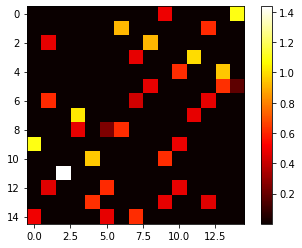

[(0, 'Bordeaux'), (14, 'Pau'), (7, 'Clermont-Ferrand'), (3, 'Lyon'), (11, 'Montpellier'), (2, 'Nice'), (8, 'Strasbourg'), (6, 'Lille'), (1, 'Paris'), (12, 'Caen'), (5, 'Brest'), (13, 'Rennes'), (4, 'Nantes'), (10, 'Angers'), (9, 'Poitiers'), (10, 'Angers')]
39.37629287990913
[(215.0, 256.0), (492.0, 386.0), (137.0, 607.0), (279.0, 498.0), (378.0, 212.0), (460.0, 80.0), (614.0, 418.0), (280.0, 419.0), (473.0, 629.0), (336.0, 296.0), (396.0, 257.0), (130.0, 455.0), (514.0, 266.0), (438.0, 206.0), (109.0, 265.0), (215.0, 256.0), (492.0, 386.0), (137.0, 607.0), (279.0, 498.0), (378.0, 212.0), (460.0, 80.0), (614.0, 418.0), (280.0, 419.0), (473.0, 629.0), (336.0, 296.0), (396.0, 257.0), (130.0, 455.0), (514.0, 266.0), (438.0, 206.0), (109.0, 265.0), (215.0, 256.0), (492.0, 386.0), (137.0, 607.0), (279.0, 498.0), (378.0, 212.0), (460.0, 80.0), (614.0, 418.0), (280.0, 419.0), (473.0, 629.0), (336.0, 296.0), (396.0, 257.0), (130.0, 455.0), (514.0, 266.0), (438.0, 206.0), (109.0, 265.0), (215.0

In [10]:
import pygame

pygame.init()

WIDTH=700
HEIGHT=700
OFFSET=WIDTH/2
screen = pygame.display.set_mode((WIDTH, HEIGHT))
done = False
is_blue = True
x = 0
y = 0
epsilon=1

font=pygame.font.Font(None, 24)
city_color = (255, 100, 0)
ant_color  = (0,255,100)
__circuit__ = []

def text_objects(text, font):
    textSurface = font.render(text, True, (255,255,255))
    return textSurface, textSurface.get_rect()

def message_display(text, coord):
    largeText = pygame.font.Font(None, 24)
    TextSurf, TextRect = text_objects(text, largeText)
    TextRect.center = coord
    screen.blit(TextSurf, TextRect)
    pygame.display.update()

def draw_map():
  # Center point
  pygame.draw.rect(screen, (255,255,255), pygame.Rect(OFFSET,OFFSET,1,1))
        
  # Draw every city position and text it
  coord_text=[]
  for i in range(len(_CITIES_N)):
     city=_CITIES_N[i]
     x_coord = OFFSET+(int)((OFFSET-200)*city[0])
     y_coord = OFFSET+(int)((OFFSET-200)*city[1])
     coord_text.append((x_coord, y_coord))
     pygame.draw.rect( screen, city_color, pygame.Rect(x_coord,y_coord, 16,16) )
     __circuit__.append((x_coord,y_coord))
  return coord_text

def display_and_clear(n, end_turn=False):
  # DISPLAY
  pygame.display.flip()

  #convert image so it can be displayed in OpenCV
  view = pygame.surfarray.array3d(screen)
  #  convert from (width, height, channel) to (height, width, channel)
  view = view.transpose([1, 0, 2])
  #  convert from rgb to bgr
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  #Display image, clear cell every 0.5 seconds
  cv2_imshow(img_bgr)

  coord_text = draw_map()
  for i in range(len(coord_text)):
    message_display(_CITIES[i][0], coord_text[i])

  time.sleep(n)
  output.clear()
  # Clean screen
  pygame.draw.rect(screen, (0,0,0), pygame.Rect(0,0,WIDTH,HEIGHT) )
  # Draw Map
  coord_text = draw_map()
  for i in range(len(coord_text)):
    message_display(_CITIES[i][0], coord_text[i])


  

while not done:
        for event in pygame.event.get():
                if event.type == pygame.QUIT:
                        done = True
        
        # Clean screen
        pygame.draw.rect(screen, (0,0,0), pygame.Rect(0,0,WIDTH,HEIGHT) )
        # Draw Map
        draw_map()
          
        #SMA ALGO FOR ANTS
        pheromones_map = Map()
        print(pheromones_map.adj_mat)
        f = Fourmi(_CITIES[0])
        
        #ALGO
        n_fourmis = 3
        fourmis= [Fourmi(_CITIES[random.randint(0,_NODES-1)]) for i in range(n_fourmis)]
        colors = [(200+i*55.0/n_fourmis,200+i*55.0/n_fourmis,200+i*55/n_fourmis) for i in range(len(fourmis))]
        for turn in range(_NODES+1):
          message_display(f"Turn {turn}", (350,350))
          for i in range(len(fourmis)):
              f=fourmis[i]
              f.move(
                  f.choose_movement(pheromones_map), 
                  pheromones_map
              )
            #GUI ANT
              x_ant,y_ant = f.coord_to_display(350, mean_x,mean_y,std_x,std_y)
              pygame.draw.circle(screen,colors[i],   (x_ant+8,y_ant+8),8,0)
              #pygame.draw.rect(screen, colors[i], pygame.Rect(x_ant, y_ant, 18, 18))
          display_and_clear(3)

        display_and_clear(1, True)
        done=True
        
        pheromones_map.print_results()
        print(__circuit__)

Adj mat of pheromones :
[[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


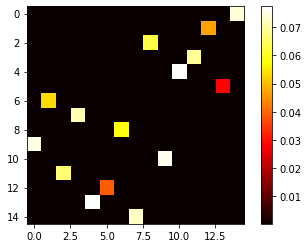

[(0, 'Bordeaux'), (14, 'Pau'), (7, 'Clermont-Ferrand'), (3, 'Lyon'), (11, 'Montpellier'), (2, 'Nice'), (8, 'Strasbourg'), (6, 'Lille'), (1, 'Paris'), (12, 'Caen'), (5, 'Brest'), (13, 'Rennes'), (4, 'Nantes'), (10, 'Angers'), (9, 'Poitiers'), (1, 'Paris')]
41.16697633171941
Agent secret au rapport
	Position actuelle : Rennes
	Villes visitées : ['Rennes', 'Nantes', 'Angers', 'Poitiers', 'Bordeaux', 'Pau', 'Clermont-Ferrand', 'Lyon', 'Montpellier', 'Nice', 'Strasbourg', 'Lille', 'Paris', 'Caen', 'Brest', 'Rennes']

40.09493752952588


In [13]:
pheromones_map = Map()
print(pheromones_map)

fourmis = [Fourmi(_CITIES[random.randint(0,_NODES-1)]) for i in range(1)]

for _ in range(1): #circuit number
    for turn in range(_NODES+1):
        print(f"Turn {turn}")
        for f in range(len(fourmis)):
            fourmis[f].move(
                fourmis[f].choose_movement(pheromones_map), 
                pheromones_map
            )
        #print(pheromones_map)
        # Add new pheromones & evaporate old ones
        #pheromones_map.pheromones_to_map()
        #Normalize them 
    [print(f) for f in fourmis]
    [print(f.path_length()) for f in fourmis]
    [print(pheromones_map.pheromones_to_add) for f in fourmis]
    print(pheromones_map.adj_mat)
    pheromones_map.normalize_pheromones()
    print(pheromones_map.adj_mat)


print(np.array([np.round(x,2) for x in pheromones_map.adj_mat]))
print(f" Shape {pheromones_map.adj_mat.shape}, type {pheromones_map.adj_mat.dtype}")

print(f"Adj mat path : ")
pheromones_map.print_results()

best_f = fourmis[np.argmax([f.path_length() for f in fourmis])]
print(best_f)
print(best_f.path_length())



In [37]:
for _ in range(1):
    fo = Fourmi(_CITIES[random.randint(0,_NODES-1)])
    for turn in range(_NODES+1):
        print(f"Turn {turn}")
        fo.move(
            fo.choose_movement(pheromones_map), 
            pheromones_map
        )
    print(fo)
    print(fo.path_length())
    #print(pheromones_map.pheromones_to_add)
    #print(pheromones_map.adj_mat)


#print(np.array([np.round(x,2) for x in pheromones_map.adj_mat]))
#print(f" Shape {pheromones_map.adj_mat.shape}, type {pheromones_map.adj_mat.dtype}")

#print(pheromones_map.print_results())

Turn 0
Turn 1
Turn 2
Turn 3
Turn 4
Turn 5
Turn 6
Turn 7
Turn 8
Turn 9
Turn 10
Turn 11
Turn 12
Turn 13
Turn 14
Turn 15
Depot des phéromones sur le circuit
Agent secret Isabelle au rapport
	Position actuelle : Nice
	Villes visitées : ['Nice', 'Strasbourg', 'Lille', 'Paris', 'Caen', 'Brest', 'Rennes', 'Nantes', 'Angers', 'Poitiers', 'Bordeaux', 'Pau', 'Clermont-Ferrand', 'Lyon', 'Montpellier', 'Nice']

40.09493752952588


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
